# Metro Interstate Traffic Volume 

Giovanne Lucas Dias Pereira Mariano, 173317, g173317@dac.unicamp.br

This project is intended to find a linear regression model able to be a good predictor for the traffic volume in one interstate metro in the USA.

It has been developed in google colab. To access the dataset the drive with the dataset should be mounted.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 1. Imports important packages and the dataset:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import accuracy_score

data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/linear-regression/Metro_Interstate_Traffic_Volume.csv")
df = pd.DataFrame(data)

print("",df.head())

   holiday    temp  ...            date_time  traffic_volume
0    None  288.28  ...  2012-10-02 09:00:00            5545
1    None  289.36  ...  2012-10-02 10:00:00            4516
2    None  289.58  ...  2012-10-02 11:00:00            4767
3    None  290.13  ...  2012-10-02 12:00:00            5026
4    None  291.14  ...  2012-10-02 13:00:00            4918

[5 rows x 9 columns]


#### 2. Assigning value to non-numerical features and rescaling:

In [3]:
# function to assign a value to the non-numerical collums
def valuation(df):
    # the holidays are signed with 1 and the regular days with 0
    dict_1 = {'None': 0.0, 'Columbus Day': 1.0, 'Veterans Day': 1.0, 'Thanksgiving Day': 1.0, 'Christmas Day': 1.0, 
              'New Years Day': 1.0, 'Washingtons Birthday': 1.0, 'Memorial Day': 1.0, 'Independence Day': 1.0, 
              'State Fair': 1.0, 'Labor Day': 1.0, 'Martin Luther King Jr Day': 1.0}
    # a weight is designated to weather_main and weather description, 
    # with the most abruptal weathers receiving higher weights
    dict_2 = {'Clear': 0.0, 'Clouds': 1.0, 'Mist': 2.0, 'Haze': 2.0, 'Fog': 2.0,  'Smoke': 2.0, 
              'Drizzle': 3.0, 'Rain': 4.0, 'Thunderstorm': 5.0, 'Snow': 5.0, 'Squall': 5.0}
    dict_3 = {'scattered clouds': 0.0, 'broken clouds': 1.0, 'overcast clouds': 1.0, 'sky is clear': 0.0, 'few clouds': 0.0, 
              'light rain': 2.0, 'light intensity drizzle': 2.0, 'mist': 1.0, 'haze': 1.0, 'fog': 1.0, 'proximity shower rain': 3.0, 
              'drizzle': 2.0, 'moderate rain': 3.0, 'heavy intensity rain': 3.0, 'proximity thunderstorm': 4.0, 
              'thunderstorm with light rain': 4.0, 'proximity thunderstorm with rain': 4.0, 'heavy snow': 4.0, 
              'heavy intensity drizzle': 2.0, 'snow': 4.0, 'thunderstorm with heavy rain': 4.0, 'freezing rain': 3.0, 
              'shower snow': 4.0, 'light rain and snow': 4.0, 'light intensity shower rain': 3.0, 'SQUALLS': 4.0, 
              'thunderstorm with rain': 4.0, 'proximity thunderstorm with drizzle': 4.0, 'thunderstorm': 4.0, 
              'Sky is Clear': 0.0, 'very heavy rain': 3.0, 'thunderstorm with light drizzle': 4.0, 'light snow': 4.0, 
              'thunderstorm with drizzle': 4.0, 'smoke': 1.0, 'shower drizzle': 2.0, 'light shower snow': 4.0, 'sleet': 4.0}
    # switch the values in the dictionary for the designated weights
    for key, value in dict_1.items():
        df.replace(key, value, inplace=True)
    for key, value in dict_3.items():
        df.replace(key, value, inplace=True)
    for key, value in dict_2.items():
        df.replace(key, value, inplace=True)
    # extracts the schedule from the date_time, since its the important info and it allows numerical analysis
    for i, value in enumerate(df['date_time']):
        df.at[i,'date_time'] = float(df.at[i,'date_time'][11:13])
    for i in range(df['traffic_volume'].size):
        df.at[i,'traffic_volume'] = float(df.at[i,'traffic_volume'])
    return df

print("Printing values for festures after evaluation of the non-numerical ones:\n", df.head())
df = valuation(df).values.astype(np.float32)

Printing values for festures after evaluation of the non-numerical ones:
   holiday    temp  ...            date_time  traffic_volume
0    None  288.28  ...  2012-10-02 09:00:00            5545
1    None  289.36  ...  2012-10-02 10:00:00            4516
2    None  289.58  ...  2012-10-02 11:00:00            4767
3    None  290.13  ...  2012-10-02 12:00:00            5026
4    None  291.14  ...  2012-10-02 13:00:00            4918

[5 rows x 9 columns]


In [4]:
# function to rescale all features: -0.5 < x < 0.5
def feat_rescale(df):
    maxx = np.max(df, axis=0)
    half = maxx / 2
    df = np.true_divide(df - half, maxx)*2
    return df

# randomly sort the data to split into train, validation ans test data sets
selection = np.random.choice(range(df.shape[0]) , df.shape[0], replace=False)
df = df[selection, :]
X = df[:,:8]
y = df[:,8]
X = feat_rescale(X)
np.set_printoptions(precision=2)
print("Data after rescaling:")
print("X example:\n", X[10000])
print("y example: ", y[10000])

Data after rescaling:
X example:
 [-1.    0.89 -1.   -1.    0.8   0.6   0.   -0.22]
y example:  5283.0


#### 3. Split the data for providing results and avoid overfitting:

In [5]:
x_test = X[0:5000, :]
x_val = X[5000:10000, :]
x_train = X[10000:X.shape[0],:]

y_test = y[0:5000]
y_val = y[5000:10000]
y_train = y[10000:y.shape[0]]
print("Printing shape of training samples.")
print("X: (number of examples, number of features): ", x_test.shape)
print("y: (number of examples,): ", y_test.shape)

Printing shape of training samples.
X: (number of examples, number of features):  (5000, 8)
y: (number of examples,):  (5000,)


#### 4. Implementation of Mini-Batch Gradient Descent:

I defined a function to compute the accuracy based on the number of predictions in a 20% acceptance range, since this would be a decent estimate for the traffic volume in a metro.

In [0]:
def hypothesis(x, theta):
    return np.dot(theta,x.T)

# A accuracy that I found to be more meaningful than regural ones
def accuracy(X, y, theta):
    # the higher the difference between predicted and real values, lower the accuracy
    summ = float(0)
    for i in range(X.shape[0]):
        y_pred = hypothesis(X[i], theta)
        if np.absolute(y_pred - y[i]) < (0.2 * y[i]):
            summ += 1
    acc = summ/X.shape[0]
    return acc

# Gradient Descent main function
def gradientDescent(X, y, m, theta, loss, alpha):
    cost = 0
    gradient = np.zeros(len(theta))
    for i in range(m):
        cost += np.square(hypothesis(X[i], theta) - y[i])
        for j in range(len(theta)):
            gradient[j] += (hypothesis(X[i], theta) - y[i]) * X[i][j]
    cost *= 1/(2*m)
    loss.append(cost)
    gradient *= 1/m
    theta -= (alpha * gradient)
    return theta

# Linear regression with Mini-Batch Gradient Descent
def linearRegression(X, y, X_val, y_val, loss, alpha = 0.001, batch_size = 100, num_iters=10):
    # Prepare data and parameters
    ones = np.ones([X.shape[0],1])
    X = np.concatenate((ones,X),axis=1)
    ones = np.ones([X_val.shape[0],1])
    X_val = np.concatenate((ones,X_val),axis=1)
    theta = np.random.uniform(0, 3, size=X.shape[1])
    # Loop through epochs and batches
    for epoch in range(num_iters):
        cost = []
        for i in range(0, X.shape[0], batch_size):
            if (i + batch_size) < X.shape[0]:
                theta = gradientDescent(X[i:i+batch_size, :], y[i:i+batch_size], batch_size, theta, cost, alpha)
            else:
                theta = gradientDescent(X[X.shape[0]-batch_size:X.shape[0], :], 
                                        y[X.shape[0]-batch_size:X.shape[0]], batch_size, theta, cost, alpha)
        loss.append(sum(cost)/len(cost))
        if (epoch == num_iters - 1) or (epoch % 5 == 0):
            print("Epoch %d: Loss %.2f" % (epoch, loss[-1]))
            print("Training accuracy = %f   -   Validation accuracy = %f" %(accuracy(X, y, theta),
                                                                            accuracy(X_val, y_val, theta)))
    return theta

In [0]:
def plot_loss(cost, alpha):
    n_iterations = [x for x in range(1,len(cost)+1)]
    plt.plot(n_iterations, cost, label=str(alpha))
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.legend(loc='upper right', shadow=False, fontsize='large')

#### 5. Execute GD-based solution for 3 different learning rates:

***************************************************************************
Epoch 0: Loss 4728034.91
Training accuracy = 0.060465   -   Validation accuracy = 0.060000
Epoch 5: Loss 1850197.16
Training accuracy = 0.177076   -   Validation accuracy = 0.167600
Epoch 10: Loss 1783872.88
Training accuracy = 0.176945   -   Validation accuracy = 0.167800
Epoch 15: Loss 1750968.70
Training accuracy = 0.175924   -   Validation accuracy = 0.170200
Epoch 20: Loss 1732859.96
Training accuracy = 0.175584   -   Validation accuracy = 0.169000
Epoch 24: Loss 1724156.48
Training accuracy = 0.175400   -   Validation accuracy = 0.168800
Theta with learning rate 0.001:
 [ 670.48 -673.17  604.7  -667.81 -663.22  240.25  -51.91 -193.01  830.41]
***************************************************************************
Epoch 0: Loss 2234251.05
Training accuracy = 0.176500   -   Validation accuracy = 0.167400
Epoch 5: Loss 1708522.32
Training accuracy = 0.170872   -   Validation accuracy = 0.165200
Epoch 10:

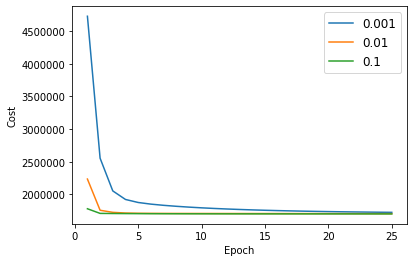

In [8]:
# defining diferent learning rates and setting hyper parameters
epochs = 25
batch_size = 256
alpha1 = 0.001
alpha2 = 0.01
alpha3 = 0.1

# executing the linear regression for different learning rates
print("*"*75)
cost = []
theta = linearRegression(x_train, y_train, x_val, y_val, cost, alpha1, batch_size, epochs)
print("Theta with learning rate 0.001:\n", theta)
print("*"*75)
plot_loss(cost, alpha1)

cost = []
theta = linearRegression(x_train, y_train, x_val, y_val, cost, alpha2, batch_size, epochs)
print("Theta with learning rate 0.01:\n", theta)
print("*"*75)
plot_loss(cost, alpha2)

cost = []
theta = linearRegression(x_train, y_train, x_val, y_val, cost, alpha3, batch_size, epochs)
print("Theta with learning rate 0.1:\n", theta)
print("*"*75)
plot_loss(cost, alpha3)

The analisys of accuracy and loss along the epochs demonstrate that there's no overfitting in this model, since the trainning, validation and test accuracies are very close to each other.

In [0]:
def normalEquation(X, y):
    x_transpose = np.transpose(X)
    x_transpose_dot_x = x_transpose.dot(X)
    temp_1 = np.linalg.inv(x_transpose_dot_x)
    temp_2 = x_transpose.dot(y)
    return temp_1.dot(temp_2)

In [10]:
# prepare data to compute accuracy and loss for all models
ones = np.ones([x_test.shape[0],1])
x_test = np.concatenate((ones,x_test),axis=1)
ones = np.ones([x_train.shape[0],1])
x_train = np.concatenate((ones,x_train),axis=1)
ones = np.ones([x_val.shape[0],1])
x_val = np.concatenate((ones,x_val),axis=1)

# prints results for MBGD
print("*"*75)
print("Linear Regression with Mini-Batch Gradient Descent (Learning Rate: 0.1)")
print("Mini-Batch GD loss: %.2f" % cost[-1])
print("Training accuracy = %.2f%%\nValidation accuracy = %.2f%%" %(accuracy(x_train, y_train, theta)*100,
                                                                        accuracy(x_val, y_val, theta)*100))
print("Test accuracy = %.2f%%" % (accuracy(x_test, y_test, theta)*100))

# compute normal equation solution and print results
normal_theta = normalEquation(x_train, y_train)
cost = 0
for i in range(x_train.shape[0]):
    cost += np.square(hypothesis(x_train[i], normal_theta) - y_train[i])
cost /= (2*x_train.shape[0])
print("*"*75)
print("Linear Regression with Normal Equation")
print("Normal equation loss: %.2f" % cost)
print("Training accuracy = %.2f%%\nValidation accuracy = %.2f%%" %(accuracy(x_train, y_train, normal_theta)*100,
                                                                        accuracy(x_val, y_val, normal_theta)*100))
print("Test accuracy = %.2f%%" % (accuracy(x_test, y_test, normal_theta)*100))

# compute sgdregressor solution and print results
sgd_model = SGDRegressor(max_iter=6000, penalty=None, eta0=0.01)
sgd_model.fit(x_train, y_train)
sgd_theta = sgd_model.coef_
print("*"*75)
print("Linear Regression with SGDRegressor")
print("Training accuracy = %.2f%%\nValidation accuracy = %.2f%%" %(accuracy(x_train, y_train, sgd_theta)*100,
                                                                        accuracy(x_val, y_val, sgd_theta)*100))
print("Test accuracy = %.2f%%" % (accuracy(x_test, y_test, sgd_theta)*100))
print("*"*75)

***************************************************************************
Linear Regression with Mini-Batch Gradient Descent (Learning Rate: 0.1)
Mini-Batch GD loss: 1700197.02
Training accuracy = 17.41%
Validation accuracy = 16.94%
Test accuracy = 17.48%
***************************************************************************
Linear Regression with Normal Equation
Normal equation loss: 1697758.63
Training accuracy = 17.40%
Validation accuracy = 16.94%
Test accuracy = 17.46%
***************************************************************************
Linear Regression with SGDRegressor
Training accuracy = 14.82%
Validation accuracy = 14.18%
Test accuracy = 14.86%
***************************************************************************


This results shows us that normal equation and GD-based solutions are almost equivalent, as expected, while the SGDRegressor didn't reached the same resuts, possibly because the parameters hasn't been studied enough to maximize the solution, but that doesn't represent a big interfence in the conclusions. However, the linear model didn't performed as good as expectations could be. Therefore, we may conclude that the dataset doesn't present a highly linearly correlated set of features or that the valuation of non-numerical features was poorly linked with domain knowledge.